In [1]:
! pip install -q kaggle
! pip install datasets
! pip install -U accelerate
! pip install -U transformers[torch]
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
!pip install evaluate
import evaluate

In [2]:
from google.colab import files
!kaggle datasets download crowdflower/twitter-airline-sentiment

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 156MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/twitter-airline-sentiment.zip','r')
zip_ref.extractall('/content/')
zip_ref.close()

We first get the dataset as as Dataframe to have a look at its shape

In [4]:
tweets = pd.read_csv('/content/Tweets.csv')
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


We want to create a column 'label' taking a numeric value for each sentiment

In [5]:
def label_sentiment(sentiment):
  if sentiment == 'negative':
    return 0
  elif sentiment == 'neutral':
    return 1
  elif sentiment == 'positive':
    return 2

tweets['label'] = tweets['airline_sentiment'].apply(label_sentiment)
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,label
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN,2
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,0
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN,1
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),0


Now we get the data as a HuggingFace Dataset

In [6]:
from datasets import load_dataset
data_files = {'train': 'Tweets.csv'}
#dataset = load_dataset('csv', data_files=['train.csv', 'validation.csv'])
dataset = load_dataset('csv', data_files=data_files)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
        num_rows: 14640
    })
})

Add the 'label' column to the HF dataset

In [7]:
dataset["train"] = dataset["train"].add_column("label", list(tweets['label']))
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'label'],
        num_rows: 14640
    })
})

In [8]:
np.unique(dataset["train"]['airline_sentiment'])

array(['negative', 'neutral', 'positive'], dtype='<U8')

There are 3 labels. What's the distribution?

In [9]:
print(pd.DataFrame(dataset["train"]).groupby('airline_sentiment').size())

airline_sentiment
negative    9178
neutral     3099
positive    2363
dtype: int64


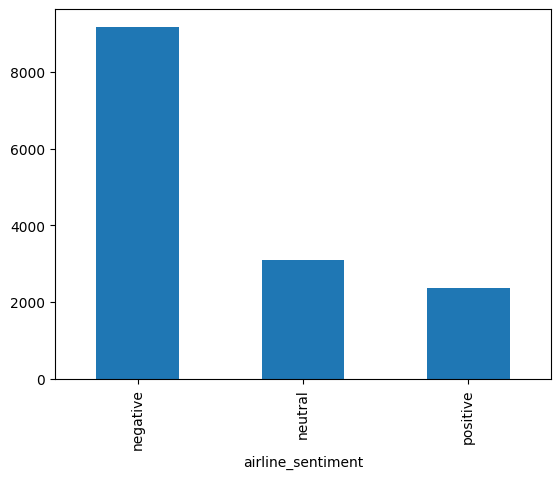

In [10]:
hist = pd.DataFrame(dataset["train"]).groupby('airline_sentiment').size().plot(kind='bar')

Train/test split

In [11]:
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'label'],
        num_rows: 13176
    })
    test: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone', 'label'],
        num_rows: 1464
    })
})

In [12]:
print(pd.DataFrame(dataset["test"]).groupby('airline_sentiment').size())

airline_sentiment
negative    912
neutral     311
positive    241
dtype: int64


The classes are balanced similary in the test sample and train sample. Let's look at the tweets text

In [13]:
dataset["train"]['text'][:30]

['@united crew has been notified, passenger moved but water not fixed. Now on tarmac two hours',
 "@AmericanAir Can you help with my Cancelled Flightled flight -- I'd like to book another flight...I've been on hold for 95 minutes and counting....",
 '@USAirways any chance of making #561?',
 '@united completely unacceptable to seat 1st class passenger into middle seat in 38 (not even premium economy)',
 '@AmericanAir I need to be back home tomorrow and no one is helping me. Please help me rebook for a flight tomorrow!',
 '@united @laurasbrown5 What does "dealing via email" have anything to do with a crappy web form that is not made for mobile devices',
 '@AmericanAir I know. Just a little cold weather humor. :)',
 "@SouthwestAir Flight 3056. Only an hour long but one of the best flights I've ever had. Kudos to flight crew and airline in general.",
 '@AmericanAir - Can you please give me a travel agent support phone number? I cant find it on your website. Thanks.',
 "@JetBlue well, the l

It's interesting to note that there are special characters such as emojis. For this notebook we'll focus on the tweet and not take into account the metadata.

In [14]:
cols_to_remove = ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
                  'negativereason', 'negativereason_confidence', 'airline',
                  'airline_sentiment_gold', 'name', 'negativereason_gold',
                  'retweet_count', 'tweet_coord', 'tweet_created',
                  'tweet_location', 'user_timezone']
dataset = dataset.remove_columns(cols_to_remove)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13176
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1464
    })
})

Load a model to preprocess the text field.

In [15]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"

Tokenize the tweets

In [17]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_tweets = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/13176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1464 [00:00<?, ? examples/s]

Dynamically pad the tweets

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Train

Get the training arguments

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

Define the model

In [20]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train the model

In [21]:
trainer.train()

Step,Training Loss
500,0.599700
1000,0.482000
1500,0.467800
2000,0.346700
2500,0.322000
3000,0.327400
3500,0.262700
4000,0.166600
4500,0.157900


TrainOutput(global_step=4941, training_loss=0.33230841890855056, metrics={'train_runtime': 493.6091, 'train_samples_per_second': 80.08, 'train_steps_per_second': 10.01, 'total_flos': 854723937489408.0, 'train_loss': 0.33230841890855056, 'epoch': 3.0})

## Evaluation

Get the model predictions on the test set

In [40]:
predictions = trainer.predict(tokenized_tweets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(1464, 3) (1464,)


Take the class with the highest predicted probability

In [41]:
preds = np.argmax(predictions.predictions, axis=-1)

The metric is the accuracy (classes aren't very unbalanced):

In [42]:
accuracy = evaluate.load("accuracy")
accuracy.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.842896174863388}

Let's investigate what cases were wrong with a confusion matrix

In [54]:
import sklearn
sklearn.metrics.confusion_matrix(predictions.label_ids, preds)

array([[847,  47,  18],
       [ 82, 200,  29],
       [ 27,  27, 187]])

To have a better understanding, we'll plot a relative confusion matrix (divided by the true labels)

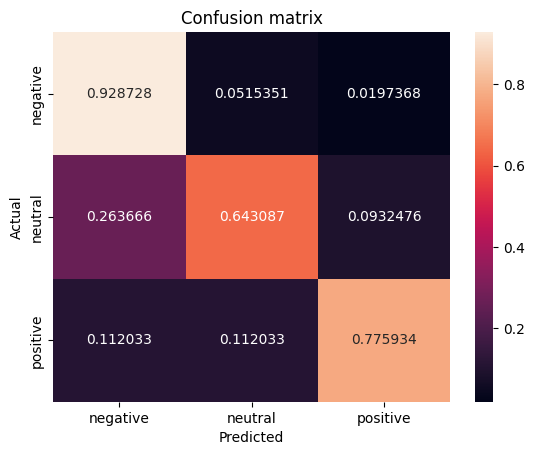

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

#mapping of labels vs sentiment
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {"negative": 0, "neutral": 1, "positive": 2}
#relative confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(predictions.label_ids, preds,
                                                    normalize='true')
#plot of the confusion matrix
p = sns.heatmap(confusion_matrix, annot=True, fmt='g')
p.set_xticklabels(id2label.values())
p.set_yticklabels(id2label.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

Overall, the model is biased towards the negative sentiment: it gets correctly the negative tweets but classifies 26% of the 'neutral' tweets as negative and
11% of the positve as negative.

## Inference

Get a text you want inference on:

In [59]:
inference_text = '@united I had a delightful flight'

In [71]:
inference_pred = trainer.predict([tokenizer(inference_text, truncation=True)])
predicted_label = np.argmax(inference_pred.predictions, axis=-1)
text_label = id2label[predicted_label[0]]
print(text_label)

positive


# Better model

We'll get customized training arguments instead of the 'test-model'

In [75]:
training_args = TrainingArguments(
    output_dir="twitter_sentiment_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_token='',
)

trainer2 = Trainer(
    model,
    training_args,
    train_dataset=tokenized_tweets["train"],
    eval_dataset=tokenized_tweets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer2.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.048000,0.947837
2,0.064900,0.918336
3,0.050800,1.056869
4,0.032200,1.184039
5,0.023800,1.179459
6,0.015100,1.155351
7,0.014200,1.182643
8,0.009700,1.252692
9,0.008700,1.295941
10,0.006200,1.304831


TrainOutput(global_step=8240, training_loss=0.027681425112543755, metrics={'train_runtime': 917.8457, 'train_samples_per_second': 143.554, 'train_steps_per_second': 8.978, 'total_flos': 3042643562606592.0, 'train_loss': 0.027681425112543755, 'epoch': 10.0})

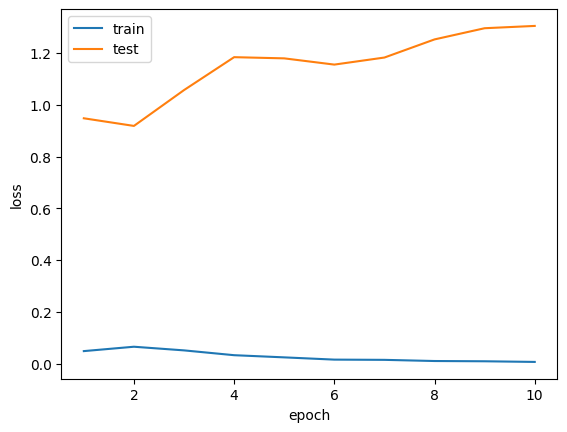

In [143]:
train_loss = [trainer2.state.log_history[0]['loss'],
              trainer2.state.log_history[3]['loss'],
              trainer2.state.log_history[5]['loss'],
              trainer2.state.log_history[8]['loss'],
              trainer2.state.log_history[11]['loss'],
              trainer2.state.log_history[13]['loss'],
              trainer2.state.log_history[16]['loss'],
              trainer2.state.log_history[19]['loss'],
              trainer2.state.log_history[21]['loss'],
              trainer2.state.log_history[24]['loss']]
test_loss = [trainer2.state.log_history[1]['eval_loss'],
              trainer2.state.log_history[4]['eval_loss'],
              trainer2.state.log_history[6]['eval_loss'],
              trainer2.state.log_history[9]['eval_loss'],
              trainer2.state.log_history[12]['eval_loss'],
              trainer2.state.log_history[14]['eval_loss'],
              trainer2.state.log_history[17]['eval_loss'],
              trainer2.state.log_history[20]['eval_loss'],
              trainer2.state.log_history[22]['eval_loss'],
              trainer2.state.log_history[25]['eval_loss']]
loss = [train_loss,test_loss]
x = np.arange(1,11,1)

plt.plot(x,loss[0],x,loss[1])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train','test'])
plt.show()

We see that we're overfitting and that our model isn't performing better after more training.